# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import sys
import os.path 
from pathlib import Path 
import copy 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from scipy.io import loadmat
import matplotlib.pyplot as plt
import random
import numpy as np

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder
# I've added a couple of other bits to make it work locally & with relative paths.

project_folder = 'Imperial_Tensorflow'
IN_COLAB = 'google.colab' in sys.modules  #Checking if this is running in Colab

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    project = Path('drive/My Drive/Colab Notebooks/') / project_folder
else:
    project = Path(os.path.dirname(os.path.realpath('__file__')))

os.chdir(project)

print('Working directory: ', os.getcwd())

Mounted at /content/drive
Working directory:  /content/drive/My Drive/Colab Notebooks/Imperial_Tensorflow


In [3]:
# Load the dataset from your Drive folder

'''
The instructions for this were wrong, the files in the link are are labeled 
digitStruct.mat and in the wrong version Instead I copied the files from the 
Coursera course folder and uploaded to gdrive. 
'''

train = loadmat('./Data/train_32x32.mat')
test = loadmat('./Data/test_32x32.mat')

from tensorflow.keras.preprocessing.image import load_img

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [5]:
x_train = tf.transpose(train['X'], [3,0,1,2])  #The original axis had samples last
x_test = tf.transpose(test['X'], [3,0,1,2])
y_train = train['y']
y_test = test['y']

x_test_images = copy.deepcopy(x_test)  # To use at the end for display
y_test_labels = copy.deepcopy(y_test)  # To use at the end for display

print('Shape of the train images array:', x_train.shape)
print('Shape of the train labels array:', y_train.shape)
print('Shape of the test images array:', x_test.shape)
print('Shape of the test labels array:', y_test.shape)

Shape of the train images array: (73257, 32, 32, 3)
Shape of the train labels array: (73257, 1)
Shape of the test images array: (26032, 32, 32, 3)
Shape of the test labels array: (26032, 1)


In [6]:
# Just taking a look at the labels
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


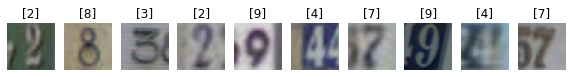

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
  selection = random.choice(range(len(x_train)))
  ax[i].set_axis_off()
  ax[i].imshow(x_train[selection])
  ax[i].set_title(y_train[selection])

  # Note, this gives a future warning from using a sliced array with pyplot.  Not sure how to fix yet.
  # plt.imshow(x_train[:,:,:,4]) on its own is OK.  So it is related to the subplots?

In [8]:
x_train = np.mean(x_train, axis=3, keepdims=True)/255  # Also scale to values from 0 to 1
x_test = np.mean(x_test, axis=3, keepdims=True)/255
y_train = y_train % 10  # so that the 10 category gets labelled as 0 to match the output nodes
y_test = y_test % 10

In [9]:
np.unique(y_train)   # Checking my label conversion worked as I hoped

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


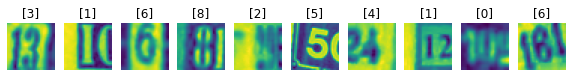

In [10]:
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
  selection = random.choice(range(len(x_train)))
  ax[i].set_axis_off()
  ax[i].imshow(x_train[selection].squeeze(axis=2))
  ax[i].set_title(y_train[selection])

It would be good to normalise the image values around zero using standard deviation and mean, but I'm not going to for this assignment.

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
# Define callbacks

def get_checkpoints(model_type):
  checkpoint_best_path = Path('Models/' + model_type + '_checkpoints_best/checkpoint')
  checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path, 
                                  save_weights_only=True, 
                                  save_freq='epoch',
                                  save_best_only=True,
                                  verbose=1)

  checkpoint_path = 'Models/' + model_type + '_checkpoints_every_epoch/checkpoint_{epoch:03d}'  # Relative to CWD!
  checkpoint_epoch = ModelCheckpoint(filepath = checkpoint_path,
                             frequency = 'epoch',
                             save_weights_only=True,
                             verbose=1) 

  early_stop = EarlyStopping(patience=5)

  return checkpoint_best, checkpoint_epoch, early_stop

In [12]:
def get_mlp_model():
  model = Sequential([
        Flatten(name='flatten', input_shape=x_train.shape[1:4]),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(10,  activation="softmax")
        ])
  
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = get_mlp_model() 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 690,314
Trainable params: 690,314
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train model
callbacks = get_checkpoints('mlp')

history = model.fit(x_train, y_train, epochs=40, 
                    validation_split=0.2, batch_size = 64, callbacks = callbacks, verbose=1)

Epoch 1/40
916/916 [==============================] - 12s 13ms/step - loss: 2.1067 - accuracy: 0.2403 - val_loss: 1.7774 - val_accuracy: 0.3774

Epoch 00001: val_loss improved from inf to 1.77744, saving model to Models/mlp_checkpoints_best/checkpoint

Epoch 00001: saving model to Models/mlp_checkpoints_every_epoch/checkpoint_001
Epoch 2/40
916/916 [==============================] - 10s 11ms/step - loss: 1.5149 - accuracy: 0.4789 - val_loss: 1.4013 - val_accuracy: 0.5297

Epoch 00002: val_loss improved from 1.77744 to 1.40131, saving model to Models/mlp_checkpoints_best/checkpoint

Epoch 00002: saving model to Models/mlp_checkpoints_every_epoch/checkpoint_002
Epoch 3/40
916/916 [==============================] - 10s 11ms/step - loss: 1.3069 - accuracy: 0.5644 - val_loss: 1.2454 - val_accuracy: 0.5947

Epoch 00003: val_loss improved from 1.40131 to 1.24541, saving model to Models/mlp_checkpoints_best/checkpoint

Epoch 00003: saving model to Models/mlp_checkpoints_every_epoch/checkpoint_

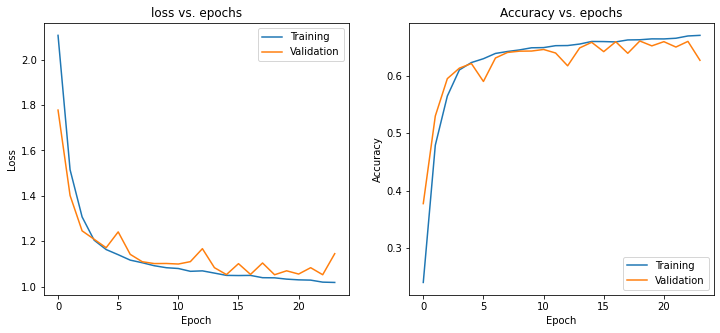

In [14]:
# Plot the history
def plot_hist(hist):
  fig = plt.figure(figsize=(12, 5))

  fig.add_subplot(121)

  plt.plot(hist['loss'])
  plt.plot(hist['val_loss'])
  plt.title('loss vs. epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  fig.add_subplot(122)

  plt.plot(hist['accuracy'])
  plt.plot(hist['val_accuracy'])
  plt.title('Accuracy vs. epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='lower right')

  plt.show()

plot_hist(history.history)

In [15]:
# Evaluate on the test set

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('Test accuracy: {acc:0.3f}'.format(acc=test_acc))
    print('Test loss: {acc:0.3f}'.format(acc=test_loss))

get_test_accuracy(model, x_test, y_test)

Test accuracy: 0.597
Test loss: 1.266


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [16]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

def get_cnn_model(wd, rate):  #wd is for the l2 regularizer, rate is dropout rate
  model = Sequential([
        Conv2D(filters=16, input_shape=x_train.shape[1:4], kernel_size=(3, 3), 
               activation='relu', padding="same", name='conv_1'),
        Dropout(rate),
        Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(2, 2), name='pool_1'),
        Flatten(name='flatten'),          
        BatchNormalization(),
        Dense(64, kernel_regularizer=regularizers.l2(wd), activation="relu", name='dense_1'),
        Dropout(rate),
        Dense(64, kernel_regularizer=regularizers.l2(wd), activation="relu", name='dense_2'),
        Dropout(rate),
        Dense(10,  activation="softmax", name='dense_3')
        ])
  
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [17]:
model = get_cnn_model(1e-5, 0.2)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [18]:
callbacks = get_checkpoints('CNN')

history = model.fit(x_train, y_train, epochs=40, 
                    validation_split=0.2, batch_size = 64, callbacks = callbacks, verbose=1)

Epoch 1/40
916/916 [==============================] - 84s 91ms/step - loss: 1.4327 - accuracy: 0.5145 - val_loss: 0.6784 - val_accuracy: 0.7927

Epoch 00001: val_loss improved from inf to 0.67841, saving model to Models/CNN_checkpoints_best/checkpoint

Epoch 00001: saving model to Models/CNN_checkpoints_every_epoch/checkpoint_001
Epoch 2/40
916/916 [==============================] - 84s 91ms/step - loss: 0.7653 - accuracy: 0.7630 - val_loss: 0.6469 - val_accuracy: 0.7980

Epoch 00002: val_loss improved from 0.67841 to 0.64693, saving model to Models/CNN_checkpoints_best/checkpoint

Epoch 00002: saving model to Models/CNN_checkpoints_every_epoch/checkpoint_002
Epoch 3/40
916/916 [==============================] - 84s 91ms/step - loss: 0.6585 - accuracy: 0.7958 - val_loss: 0.5440 - val_accuracy: 0.8342

Epoch 00003: val_loss improved from 0.64693 to 0.54395, saving model to Models/CNN_checkpoints_best/checkpoint

Epoch 00003: saving model to Models/CNN_checkpoints_every_epoch/checkpoint_

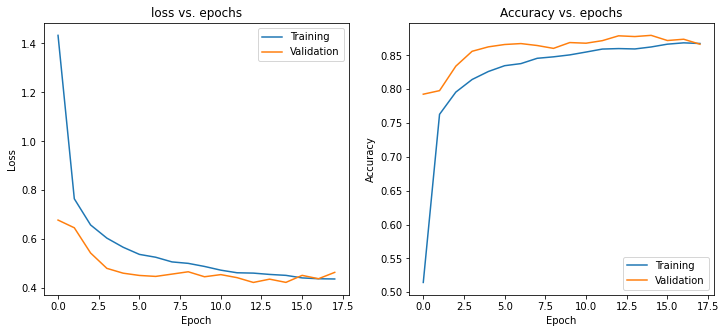

In [19]:
plot_hist(history.history)

In [20]:
get_test_accuracy(model, x_test, y_test)
del model

Test accuracy: 0.854
Test loss: 0.508


In [21]:
cnn_model = get_cnn_model(1e-5, 0.2)
mlp_model = get_mlp_model()

cnn_model.load_weights('Models/CNN_checkpoints_best/checkpoint')
mlp_model.load_weights('Models/mlp_checkpoints_best/checkpoint')

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

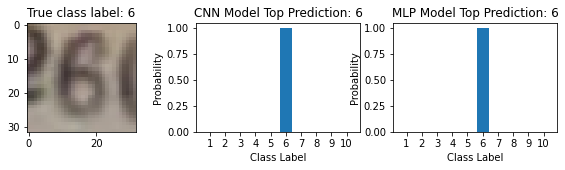

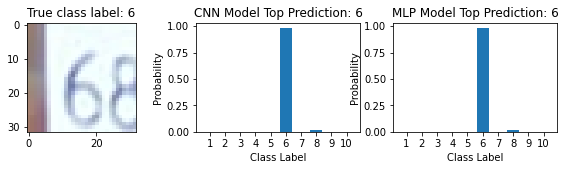

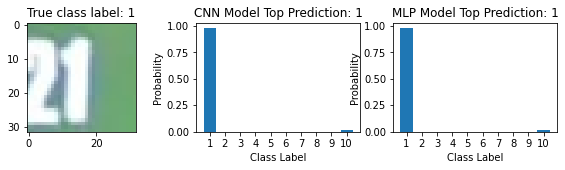

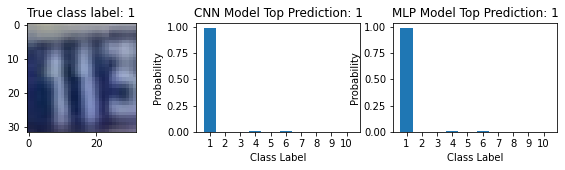

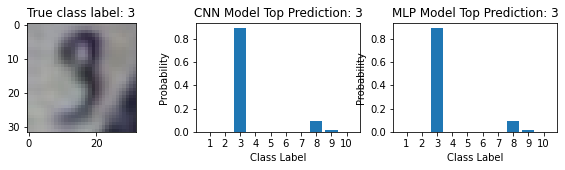

In [22]:
labels = [10,1,2,3,4,5,6,7,8,9]

selection = random.sample(range(len(x_test)), 5)

for sample in selection:

  x_test_img = x_test[sample][np.newaxis, ...]
  cnn_preds = cnn_model.predict(x_test_img)
  cnn_prediction = labels[np.argmax(cnn_preds)]
  mlp_preds = cnn_model.predict(x_test_img)
  mlp_prediction = labels[np.argmax(mlp_preds)]
  true_label = y_test_labels[sample]
  
  fig = plt.figure(figsize=(10,2))

  fig.add_subplot(131)
  plt.title('True class label: %i' % true_label)
  plt.imshow(x_test_images[sample])

  fig.add_subplot(132)

  plt.ylabel('Probability')
  plt.xlabel('Class Label')
  plt.xticks(np.arange(1, 11, 1))
  plt.title('CNN Model Top Prediction: %i' % cnn_prediction)
  plt.bar(labels, cnn_preds[0])

  fig.add_subplot(133)

  plt.ylabel('Probability')
  plt.xlabel('Class Label')
  plt.xticks(np.arange(1, 11, 1))
  plt.title('MLP Model Top Prediction: %i' % mlp_prediction)
  plt.bar(labels, cnn_preds[0])

  plt.show()

